In [17]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

from sklearn.metrics import accuracy_score  

### Regression

In statistical modeling, regression analysis is a set of **statistical processes** for estimating the relationships between a dependent variable (often called the 'target' variable) and one or more independent variables (often called 'features'). This allows the analyst to estimate the conditional expectation of the dependent variable when the independent variables take on a given set of values. 

There are various methods to perform Regression prediction. This notebook shows two methods:- 

* Linear Regression: Linear regression finds the line (or a more complex linear combination) that most **closely fits** the data according to a specific mathematical criterion. For example, the method of ordinary least squares computes the unique line (or hyperplane) that minimizes the sum of squared differences between the true data and that line (or hyperplane). 


* Decision Tree: Decision tree builds regression models in the form of a tree structure. It **breaks down a dataset** into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with **decision nodes** and **leaf nodes**.

**Datasets**
<p>
    <b>Advertisement</b>: Prediction of sales<br><br>
    Features
            <li>Radio: Revenue generated through radio</li>
            <li>Radio: Revenue generated through radio</li>
         
Target
            <li>Sales: Total Sales</li>
</p>

<p>
    <b>Car Sales</b>: Prediction of car sales<br><br>
    Features
            <li>SupplierName: Name of car supplier</li>
            <li>Car Manufacturers: Car Manufacturerers </li>
            <li>CarModel: Model of car</li>
            <li>CarColor: Color of car</li>
            <li>CarModelYear: Model year of car</li>
            <li>CarPrice: Price of car</li>

Target
            <li>Sales: Car sales</li>
</p>

<p>
    <b>Steel Consumption</b>: Forecasting monthly steel consumption<br><br>
    Features
            <li>Months: Number of months passed</li>
            <li>id: Steel ID</li>

Target
            <li>Consumption: Monthly steel consumption</li>
</p>

In [18]:
print(""" Datasets to choose
1. Advertisement
2. Car Sales
3. Steel Consumption
""")
choice = int(input('Enter: '))

if choice == 1:
    data_name = 'advertising'
elif choice == 2:
    data_name = 'CarSales'
else:
    data_name = 'SteelConsumption'

df = pd.read_csv(f'{data_name}.csv').iloc[:, 1:]
target = df.columns[:-1]
df

 Datasets to choose
1. Advertisement
2. Car Sales
3. Steel Consumption

Enter: 2


,SupplierName,CarMaker,CarModel,CarColor,CarModelYear,CarPrice,Sales
0,Edgetag,Chevrolet,Corvette,Indigo,1953,532923.48,890076.42
1,Zoomzone,Pontiac,Grand Prix,Aquamarine,1962,784238.63,862877.87
2,Feednation,Chevrolet,Corvette,Purple,1962,600728.74,775084.20
3,Feedmix,Ford,Galaxie,Red,1964,505333.49,974787.89
4,Yodo,Austin,Mini Cooper,Indigo,1964,717807.54,777048.56
...,...,...,...,...,...,...,...
95,Yodel,Ford,Tempo,Turquoise,1988,686028.43,927054.81
96,Feedfire,Subaru,Justy,Crimson,1988,798573.59,902866.47
97,Youfeed,Subaru,Justy,Yellow,1988,770428.67,843893.64
98,Babbleset,Buick,Skylark,Purple,1989,575307.81,885763.43


In [19]:
df.info() # Allows to get information about all columns in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SupplierName  100 non-null    object 
 1   CarMaker      100 non-null    object 
 2   CarModel      100 non-null    object 
 3   CarColor      100 non-null    object 
 4   CarModelYear  100 non-null    int64  
 5   CarPrice      100 non-null    float64
 6   Sales         100 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


In [20]:
# Seperated numerical and non numerical features
data_types = {k.name: v for k, v in df.columns.to_series().groupby(df.dtypes).groups.items()}
try:
    categorical_columns = data_types['object']
except:
    categorical_columns = []
cont_columns = [col for col in df.columns if col not in categorical_columns]

In [21]:
df.describe() # Shows the different stats respective to the columns in the dataset

,CarModelYear,CarPrice,Sales
count,100.000000,100.000000,100.000000
mean,1982.000000,659842.234300,852075.277700
std,7.792771,89023.819537,86629.580181
min,1953.000000,501528.570000,703612.230000
25%,1981.750000,575052.760000,777752.705000
50%,1985.000000,674722.400000,856106.425000
75%,1987.000000,732981.027500,924356.635000
max,1989.000000,798573.590000,996374.150000


In [22]:
# Below figures shows the relation of different columns with respect to each other.
# This helps us to find the correlation between different variables
fig = px.scatter_matrix(df[cont_columns])
fig.show()

In [23]:
df.corr() # Shows the correlation of all continuous variables

,CarModelYear,CarPrice,Sales
CarModelYear,1.000000,0.077011,0.153092
CarPrice,0.077011,1.000000,-0.153157
Sales,0.153092,-0.153157,1.000000


**Encoding**

Encoding of categorical variables is necessary before input the data into the machine learning model. Hence the encoding here is done by converting the nominal values to ordinal

In [24]:
def nominal_to_ordinal(df, cat, target):
    group = df.groupby([cat], as_index=False)[target].mean().sort_values(target)
    cat_list = group[cat].values
    feature_encoder = {cat_list[i]:i for i in range(len(cat_list))}
    fig = go.Figure()
    fig.add_trace(go.Bar(y = group[target], x=group[cat]))
    fig.update_xaxes(title_text=cat)
    fig.update_yaxes(title_text=target)
    df[cat] = df[cat].map(feature_encoder)
    return fig

In [25]:
target = df.columns[-1]
for cat in categorical_columns:
    fig = nominal_to_ordinal(df, cat, target)
    fig.show()

In [26]:
df.head()

,SupplierName,CarMaker,CarModel,CarColor,CarModelYear,CarPrice,Sales
0,60,11,29,12,1953,532923.48,890076.42
1,54,4,31,13,1962,784238.63,862877.87
2,19,11,29,4,1962,600728.74,775084.20
3,87,13,63,9,1964,505333.49,974787.89
4,21,3,15,12,1964,717807.54,777048.56


In [27]:
df.corr() # Changes in Correlation after encoding

,SupplierName,CarMaker,CarModel,CarColor,CarModelYear,CarPrice,Sales
SupplierName,1.000000,0.526198,0.836913,0.295059,0.156710,-0.166203,0.940100
CarMaker,0.526198,1.000000,0.520018,0.208225,0.215922,-0.101696,0.458774
CarModel,0.836913,0.520018,1.000000,0.253857,0.181889,-0.151548,0.870622
CarColor,0.295059,0.208225,0.253857,1.000000,0.073701,-0.015354,0.315588
CarModelYear,0.156710,0.215922,0.181889,0.073701,1.000000,0.077011,0.153092
CarPrice,-0.166203,-0.101696,-0.151548,-0.015354,0.077011,1.000000,-0.153157
Sales,0.940100,0.458774,0.870622,0.315588,0.153092,-0.153157,1.000000


In [28]:
np.random.seed(0)
features = df.columns[:-1]
if target == 'Consumption':
    X_train, y_train = df[df['months'] <= 47][features],df[df['months'] <= 47]['Consumption'] 
    X_test, y_test = df[df['months'] == 47][features],df[df['months'] == 47]['Consumption']
else:
    X = df[features]
    y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Accuracy: 94.41825109324174
RMSE: 19483.43472718615
MAE: 16457.199146464707
R2: 0.9362939607583081


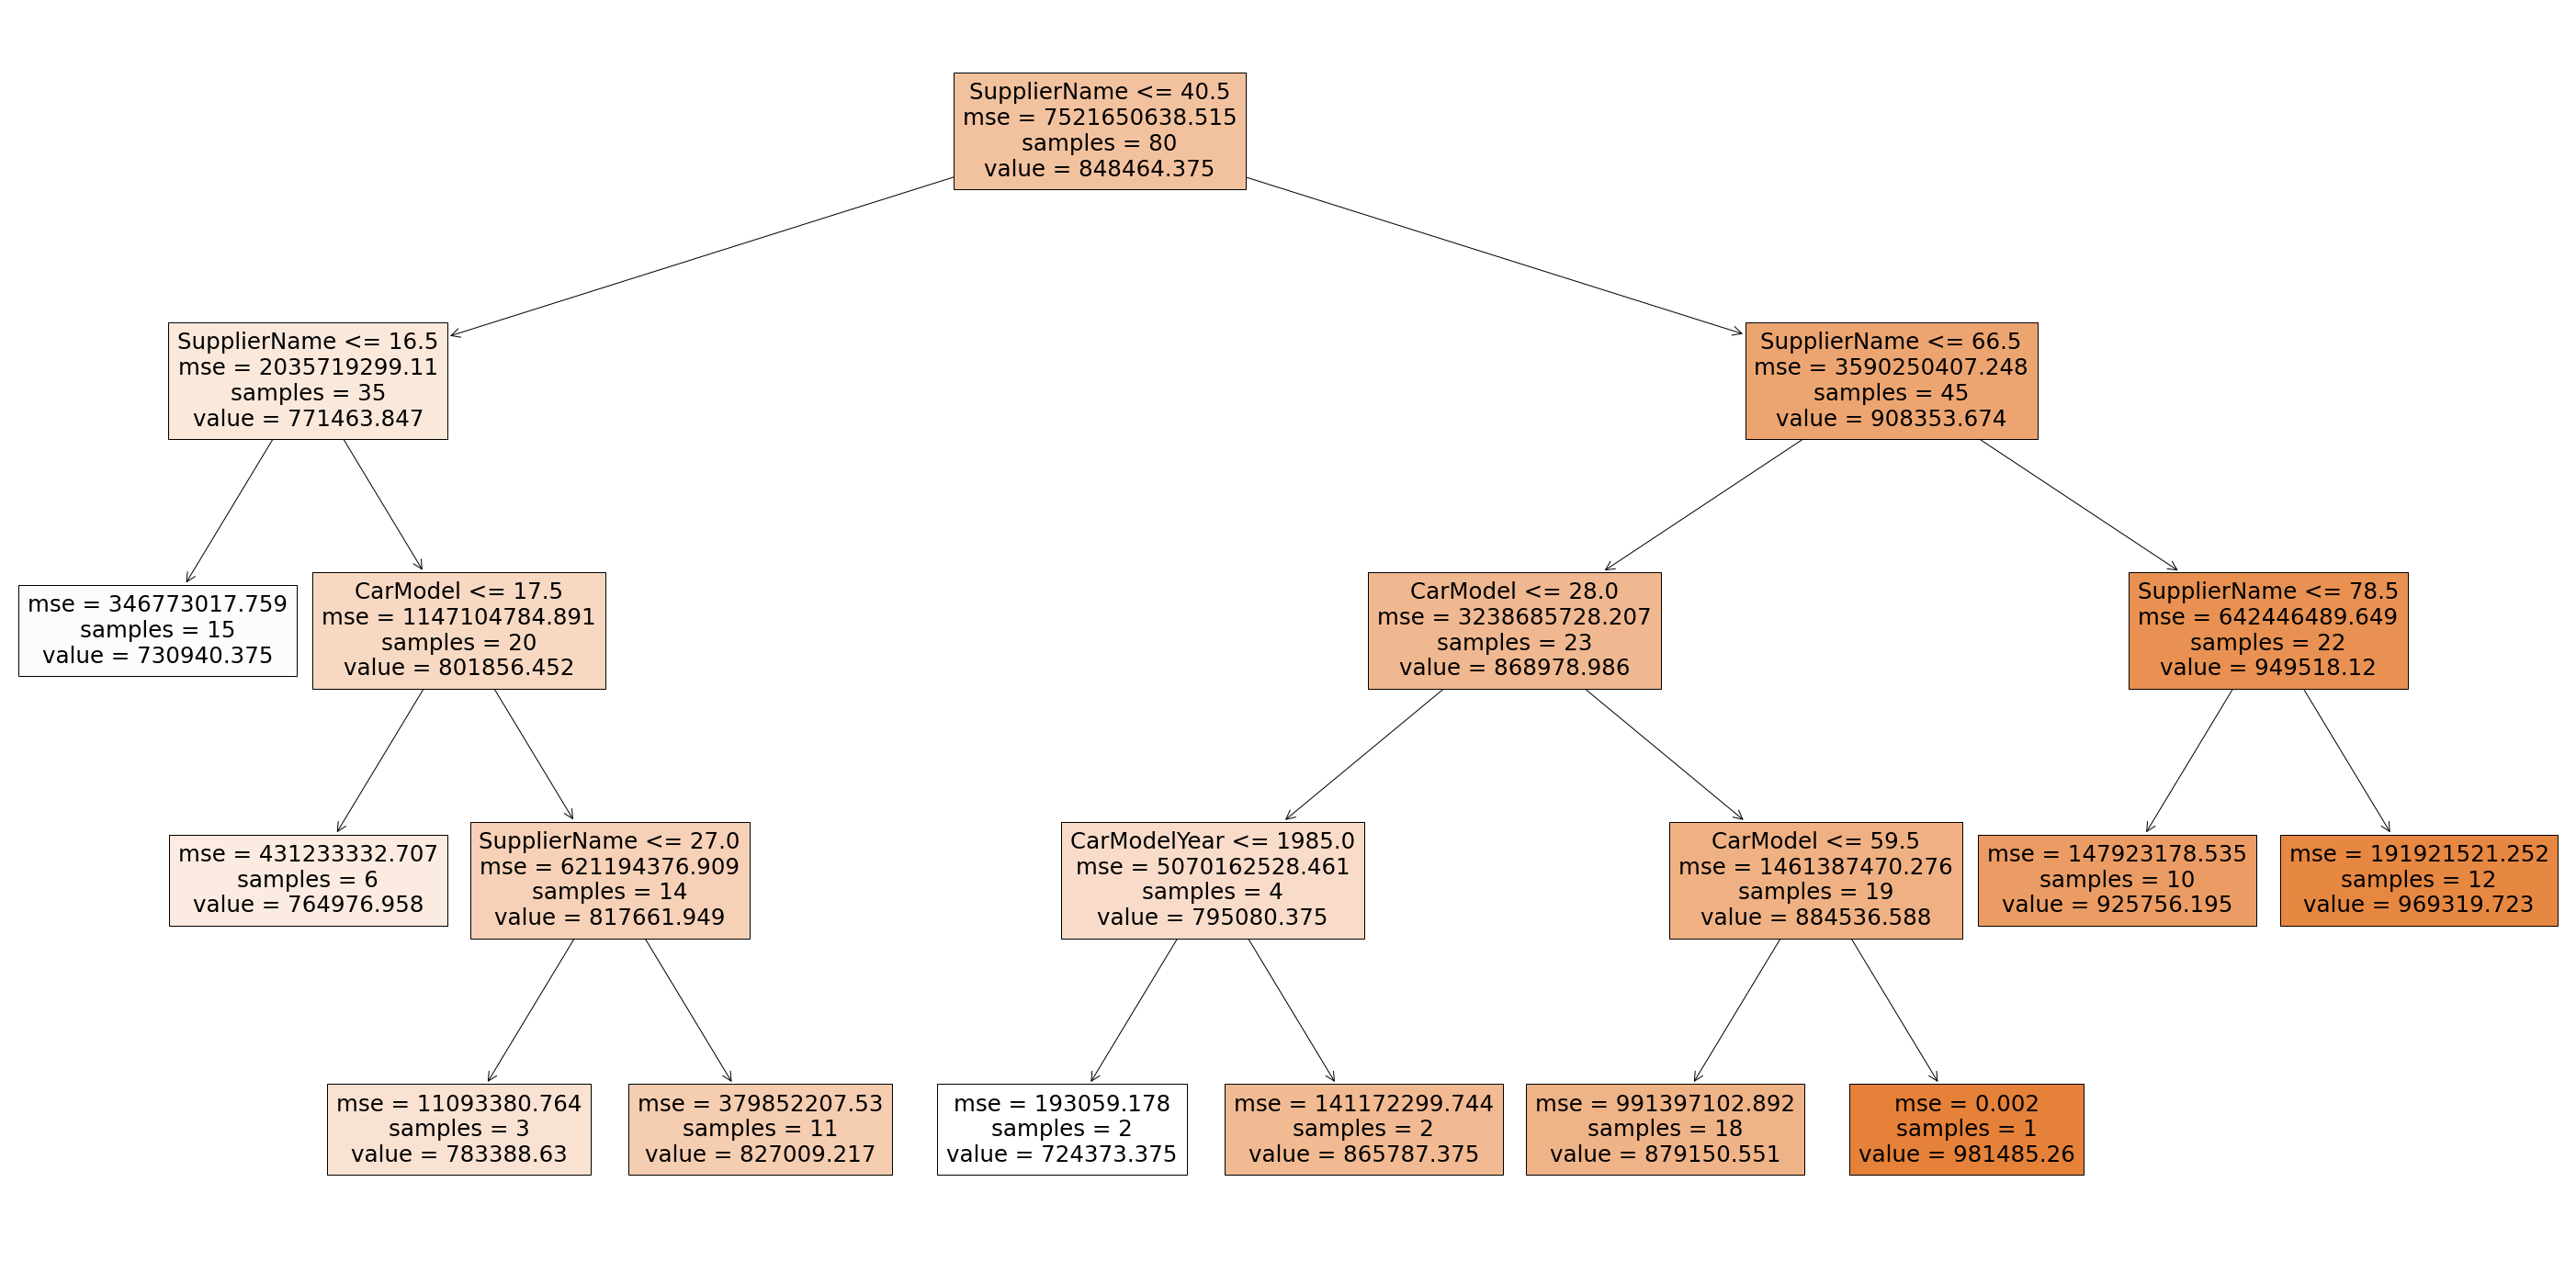

In [29]:
# Number of Leaf Nodes and depth of tree are important factors that can lead in improving the model predicision 
max_leaf_nodes, max_depth = 10, 10
model = tree.DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, max_depth=max_depth)
print("Accuracy:", model.fit(X_train, y_train).score(X_test, y_test)*100)
print(f"RMSE: {np.sqrt(mean_squared_error(model.predict(X_test), y_test))}")
print(f"MAE: {mean_absolute_error(model.predict(X_test), y_test)}")
print(f"R2: {r2_score(model.predict(X_test), y_test)}")
fig = plt.figure(figsize = (50, 25))
_=tree.plot_tree(model, feature_names = features, filled=True)

In [30]:
num = len(y_test)
fig = go.Figure()
if target == 'Consumption':
    fig.add_trace(go.Bar(y = y_test.values[:num],x = [_ for _ in range(len(y_test.values[:num]))], name='Actual'))
    fig.add_trace(go.Bar(y = model.predict(X_test[:num]),x = [_ for _ in range(len(y_test.values[:num]))], name='Prediction'))
    fig.update_xaxes(title_text='35 steel ids')
else:
    fig.add_trace(go.Scatter(y = y_test.values[:num],x = [_ for _ in range(len(y_test.values[:num]))], name='Actual'))
    fig.add_trace(go.Scatter(y = model.predict(X_test[:num]),x = [_ for _ in range(len(y_test.values[:num]))], name='Prediction'))
#     fig.update_xaxes(title_text='35 steel ids')
    fig.update_traces(mode = 'lines+markers')
fig.update_yaxes(title_text=f'{target}')

fig.update_layout(
    font=dict(
        family="bold",
        size=18,
    )
)